# Control hardware: pulse optimization under realistic experimental constraints
**Highly flexible optimizer for hardware-limited signal generation and non-ideal control lines**

BOULDER OPAL provides a large, modular collection of configuration options in order to support a wide variety of signal generators, control lines and quantum hardware. In this guide, we provide an overview of the BOULDER OPAL optimization engine, together with a set of examples that demonstrate how this engine can be tailored to model realistic constraints on the signal generation, including transients and bandwidth limits. After an overview of the engine in the first section, we show in the second section how to deal with these issues by incorporating filters in the control signal. This can also be used to design a pulse where the natural filtering properties of the control line are known. In the third section, we present a simpler approach to deal with band-limited signals by constraining the rate of change in the control pulse. Finally, in the last section we show how to create optimizations using arbitrary basis functions.

## Imports and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

formatter = EngFormatter(unit="")
plt.style.use(get_qctrl_style())

# Starting a session with the API
qctrl = Qctrl()

# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

## Overview of the BOULDER OPAL optimization engine

Standard optimal control techniques such as [GRAPE](https://www.sciencedirect.com/science/article/abs/pii/S1090780704003696) have seen widespread success in recent years, but their flexibility is typically limited by enforcing very specific Hamiltonian structures. Specifically, a standard GRAPE implementation requires that the Hamiltonian be expressed as a sum of terms that are directly and independently controllable. This assumption, while valid in some cases, is not adequate for many systems. For example, if there is non-linear dependence between controllable parameters and Hamiltonian terms, or alternatively if multiple Hamiltonian terms depend on the same underlying controls, the system cannot be coerced into the form required by GRAPE. Similarly, with standard techniques, creating optimized controls that exhibit temporal structure such as time symmetry or bandwidth limits is possible only by implementing changes in the algorithm itself (as opposed to simply changing its inputs).

The BOULDER OPAL optimization engine resolves these issues by allowing the user to express their system Hamiltonians as almost-arbitrary functions of the controllable parameters. That is, rather than enforcing a specific Hamiltonian structure and allowing the user to define the values of specific operators in that structure, the BOULDER OPAL optimization engine allows the user to define the entire Hamiltonian. This flexibility is enabled by leveraging the [TensorFlow](https://www.tensorflow.org/) automatic differentiation library. Using simple convenience functions provided by BOULDER OPAL, the user creates a representation of their system that defines a map from controllable parameters to Hamiltonian. The underlying structure of this map is a TensorFlow graph, which can be efficiently evaluated and differentiated. Once constructed, this mapping (or graph) is then inserted into the optimization cost function calculation. The resulting optimized controls thus achieve the desired objectives, and do so within the constraints imposed by the user-defined Hamiltonian structure.

Speaking concretely, in the code samples in this notebook, the `create_graph` contexts create these user-defined graphs. All steps within the context are entirely customizable by the user, although a typical flow is to:
1. Create "signals", or scalar-valued functions of time, which may be non-linear, have enforced temporal structure such as time symmetry, or more generally may depend arbitrarily on the controllable parameters;
1. Create "operators", or operator-valued functions of time, by modulating constant operators by signals;
1. Combine the operators into a single Hamiltonian operator;
1. Calculate the optimization cost function (typically an infidelity) from the Hamiltonian.

Once this graph has been defined, it is passed to the `qctrl.functions.calculate_optimization` function in order to run the optimization and produce the optimized controls.

## Smoothing control pulses using linear filters
    
In this section we present examples showing how linear time-invariant filters may be incorporated into an optimization. This is the relevant scenario when trying to model and design pulses that go through control lines in which electronic filters are naturally present. Failing to take the filter into account during the optimization can lead to poor results, since in that case the system used for the optimization does not accurately model reality. Adding filters is also an appropriate strategy to deliberately smooth out control pulses that would otherwise be badly implemented due to the characteristics of the signal generators themselves, such as bandwidth limits or specific resonances. To exemplify the use of filters, we consider a basic single-qubit system described by the Hamiltonian:

\begin{align*}
H(t) &= \frac{1}{2} L(\alpha)(t)\sigma_{x} + \beta(t) \sigma_{z} \,, 
\end{align*}

where $\alpha(t)$ is a real time-dependent pulse, $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process, and $ L$ is the filter applied to the $\alpha(t)$ pulse. The effect of the filter is to transform the control signal before it reaches the quantum system, via convolution with the filter impulse response.

BOULDER OPAL provides convenience functions for transforming a piecewise-constant signal by a linear time-invariant filter, and for producing impulse response functions representing such filters. 

### Low-pass sinc filter

In this example, we use an in-built BOULDER OPAL function to produce the sinc filter to smooth the control pulse. From the optimizations we output two sets of signals: the raw piecewise-constant signal and its smoothed version. The latter is the filtered signal that actually reaches the quantum system and performs the optimized gate. 

Your task calculate_optimization has completed in 4s.
Cost: 1.3510723749375403e-09





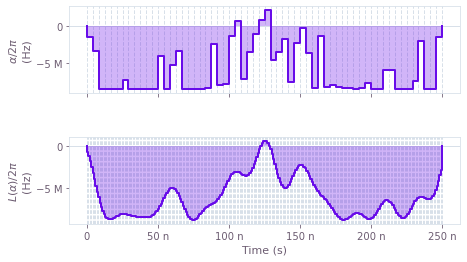

In [2]:
# Define physical constraints
alpha_max = 2 * np.pi * 8.5e6  # Hz
sinc_cutoff_frequency = 2 * np.pi * 48e6  # Hz
segments_count = 60
duration = 250e-9  # s

with qctrl.create_graph() as graph:
    # Create alpha(t) signal
    alpha = qctrl.operations.pwc_signal(
        values=qctrl.operations.bounded_optimization_variable(
            count=segments_count,
            lower_bound=-alpha_max,
            upper_bound=alpha_max,
        ),
        duration=duration,
        name="$\\alpha$",
    )

    # Create filtered signal
    sinc_filter = qctrl.operations.sinc_integral_function(sinc_cutoff_frequency)
    alpha_filtered = qctrl.operations.convolve_pwc(
        pwc=alpha,
        kernel_integral=sinc_filter,
    )
    rediscretized_alpha = qctrl.operations.discretize_stf(
        stf=alpha_filtered,
        duration=duration,
        segments_count=256,
        name="$L(\\alpha)$",
    )

    # Create control term
    control_sigma_x = qctrl.operations.pwc_operator(
        signal=rediscretized_alpha,
        operator=sigma_x / 2,
    )

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )

    # Create infidelity
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=control_sigma_x,
        target_operator=qctrl.operations.target(sigma_x),
        noise_operators=[dephasing],
        name="infidelity",
    )

# Run the optimization
result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["$\\alpha$", "$L(\\alpha)$"],
    optimization_count=1,
)

print(f"Cost: {result.cost}")

# Visualize controls
print("\n\n")
plot_controls(plt.figure(), result.output)
plt.show()

Unfiltered (top) and filtered (bottom) control amplitudes as a function of time.

In this example, we re-discretized the filtered pulse to plot it as a finely-grained piecewise-constant plot that can be compared to its unfiltered counterpart. The re-discretization can be skipped if plotting the filtered controls is not desired, as exemplified in the [Optimization user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization).

## Optimization with band-limited pulses

In this section, we show how to optimize a system in which the rates of change of the controls are limited. Using this constraint can help to ensure that optimized controls can be reliably implemented on physical hardware (which may be subject to bandwidth limits, for example). We consider a standard single-qubit system subject to dephasing noise:

\begin{align*}
H(t) &= \frac{1}{2} \alpha_1(t)\sigma_{x} + \frac{1}{2} \alpha_2(t)\sigma_{z} + \beta(t) \sigma_{z}  \,, 
\end{align*}

where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulses and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process. In this case, we enforce a maximum slew rate constraint on $\alpha_k(t)$ to cap the variation between adjacent segment values.

### Band limitation via bounded slew rates

To implement a bounded slew rate, we create signal values using a BOULDER OPAL helper function, `anchored_difference_bounded_variables`. This function produces values that are constrained to satisfy the slew rate requirement, and in addition are anchored to zero at the start and end of the gate.

Your task calculate_optimization has started.
Your task calculate_optimization has completed in 53s.
Cost: 1.8161949770245552e-12





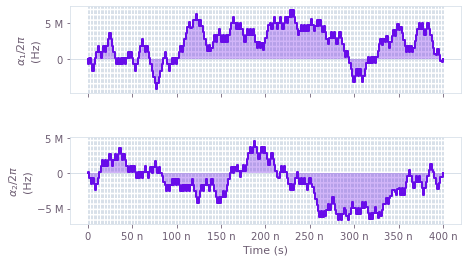

In [3]:
# Define physical constraints
alpha_max = 2 * np.pi * 8.5e6  # Hz
max_slew_rate = alpha_max / 10
segments_count = 250
duration = 400e-9  # s

with qctrl.create_graph() as graph:
    # Create alpha_1(t) signal
    alpha_1 = qctrl.operations.pwc_signal(
        values=qctrl.operations.anchored_difference_bounded_variables(
            count=segments_count,
            lower_bound=-alpha_max,
            upper_bound=alpha_max,
            difference_bound=max_slew_rate,
        ),
        duration=duration,
        name="$\\alpha_1$",
    )

    # Create alpha_2(t) signal
    alpha_2 = qctrl.operations.pwc_signal(
        values=qctrl.operations.anchored_difference_bounded_variables(
            count=segments_count,
            lower_bound=-alpha_max,
            upper_bound=alpha_max,
            difference_bound=max_slew_rate,
        ),
        duration=duration,
        name="$\\alpha_2$",
    )

    # Create control terms
    control_x = qctrl.operations.pwc_operator(
        signal=alpha_1,
        operator=sigma_x / 2,
    )
    control_z = qctrl.operations.pwc_operator(
        signal=alpha_2,
        operator=sigma_z / 2,
    )

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )

    # Create infidelity
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=qctrl.operations.pwc_sum([control_x, control_z]),
        target_operator=qctrl.operations.target(sigma_y),
        noise_operators=[dephasing],
        name="infidelity",
    )

# Run the optimization
result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["$\\alpha_1$", "$\\alpha_2$"],
    optimization_count=10,
)

print(f"Cost: {result.cost}")

# Visualize optimized pulses
print("\n\n")
plot_controls(plt.figure(), result.output)
plt.show()

Pulse amplitudes obtained from a bound slew optimization for $\alpha_1(t)$ (top) and $\alpha_2(t)$ (bottom).

### Band limitation via discretized smooth functions

An alternative approach to band limitation is to apply a filter that removes the higher frequencies from the signal, and then convert the signal again into a piecewise constant pulse. If we additionally multiply the values of the signal by an envelope function that goes to zero at its extremities, we effectively anchor the beginning and the end of the pulse at zero. In the code cell below, we use this approach to optimize a pulse in the same physical setting as the previous subsection.

Your task calculate_optimization has completed in 4s.
Cost: 1.0317142681413011e-10





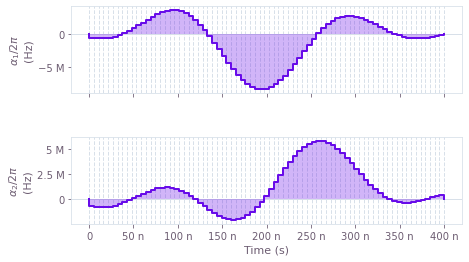

In [4]:
# Define physical constraints
alpha_max = 2 * np.pi * 8.5e6  # Hz
segments_count = 75
duration = 400e-9  # s
cutoff_frequency = segments_count / duration / 4

envelope_function = 1 - np.abs(np.linspace(-1.0, 1.0, segments_count + 2)[1:-1])

with qctrl.create_graph() as graph:
    # Create alpha_1(t) signal
    alpha_1_values = qctrl.operations.bounded_optimization_variable(
        count=segments_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )

    anchored_alpha_1_values = alpha_1_values * envelope_function

    alpha_1 = qctrl.operations.pwc_signal(
        values=anchored_alpha_1_values,
        duration=duration,
    )

    # Create alpha_2(t) signal
    alpha_2_values = qctrl.operations.bounded_optimization_variable(
        count=segments_count,
        lower_bound=-alpha_max,
        upper_bound=alpha_max,
    )

    anchored_alpha_2_values = alpha_2_values * envelope_function

    alpha_2 = qctrl.operations.pwc_signal(
        values=anchored_alpha_2_values,
        duration=duration,
    )

    # Remove higher frequencies
    sinc_filter = qctrl.operations.sinc_integral_function(cutoff_frequency)
    alpha_1_filtered = qctrl.operations.convolve_pwc(
        pwc=alpha_1,
        kernel_integral=sinc_filter,
    )
    alpha_2_filtered = qctrl.operations.convolve_pwc(
        pwc=alpha_2,
        kernel_integral=sinc_filter,
    )

    # Re-discretize signal
    rediscretized_alpha_1 = qctrl.operations.discretize_stf(
        stf=alpha_1_filtered,
        duration=duration,
        segments_count=segments_count,
        name="$\\alpha_1$",
    )
    rediscretized_alpha_2 = qctrl.operations.discretize_stf(
        stf=alpha_2_filtered,
        duration=duration,
        segments_count=segments_count,
        name="$\\alpha_2$",
    )

    # Create control terms
    control_x = qctrl.operations.pwc_operator(
        signal=rediscretized_alpha_1,
        operator=sigma_x / 2,
    )
    control_z = qctrl.operations.pwc_operator(
        signal=rediscretized_alpha_2,
        operator=sigma_z / 2,
    )

    # Create dephasing noise term
    dephasing = qctrl.operations.constant_pwc_operator(
        duration=duration, operator=sigma_z / duration
    )

    # Create infidelity
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=qctrl.operations.pwc_sum([control_x, control_z]),
        target_operator=qctrl.operations.target(sigma_y),
        noise_operators=[dephasing],
        name="infidelity",
    )

# Run the optimization
result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["$\\alpha_1$", "$\\alpha_2$"],
    optimization_count=5,
)

print(f"Cost: {result.cost}")

# Visualize optimized pulses
print("\n\n")
plot_controls(plt.figure(), result.output)
plt.show()

Pulse amplitudes obtained from a band-limited optimization with anchored filtered pulses for $\alpha_1(t)$ (top) and $\alpha_2(t)$ (bottom).

## Optimization using arbitrary basis functions

In many situations, using an appropriate set of basis functions can greatly reduce the dimensionality of the search space in an optimization problem. In **C**hopped **RA**ndom **B**asis (CRAB) optimization, for example, pulses are defined via optimizable linear combinations from the basis functions set. Traditionally, a [randomized Fourier basis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.190501) is used, although the same technique has also seen success with other bases, for example [Slepian functions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.062346). In this example, we perform a CRAB optimization (in the Fourier basis) of a qutrit system in which we effect a single-qubit gate while minimizing leakage out of the computational subspace. The system is described by the following Hamiltonian:

\begin{align*}
H(t) = & \frac{\chi}{2} (a^\dagger)^2 a^2 + \gamma(t) a + \gamma^*(t) a^\dagger + \frac{\alpha(t)}{2} a^\dagger a \,, 
\end{align*}

where $\chi$ is the anharmonicity, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, and $a = |0 \rangle \langle 1 | + \sqrt{2} |1 \rangle \langle 2 |$.

BOULDER OPAL provides a convenience function for creating optimizable signals in a Fourier basis, suitable for use in a CRAB optimization. Other bases are supported by the framework, but require the user to manually provide operations that compute the appropriate linear combinations.

Your task calculate_optimization has completed in 4s.
Cost: 1.0777823078456095e-11





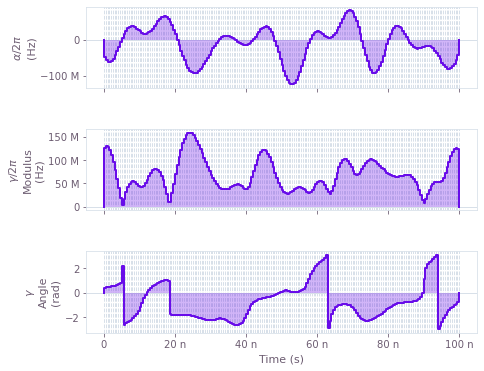

In [5]:
# Define standard matrices
a = np.array(
    [[0.0, 1.0, 0.0], [0.0, 0.0, np.sqrt(2)], [0.0, 0.0, 0.0]], dtype=np.complex
)
ada = np.matmul(a.T, a)
ad2a2 = np.matmul(np.matmul(a.T, a.T), np.matmul(a, a))
hadamard = np.array(
    [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, 0]], dtype=np.complex
) / np.sqrt(2)

# Define physical constraints
chi = 2 * np.pi * -300.0 * 1e6  # Hz
gamma_max = 2 * np.pi * 30e6  # Hz
alpha_max = 2 * np.pi * 30e6  # Hz
segments_count = 200
duration = 100e-9  # s

with qctrl.create_graph() as graph:
    # Create gamma(t) signal in Fourier bases. To demonstrate the full
    # flexibility, we show how to use both randomized and optimizable
    # basis elements. Elements with fixed frequencies may be chosen too.
    gamma_i = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segments_count,
        randomized_frequencies_count=10,
    )
    gamma_q = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segments_count,
        randomized_frequencies_count=10,
    )
    gamma = qctrl.operations.tensor_pwc(
        gamma_i.durations,
        qctrl.operations.complex_value(real=gamma_i.values, imag=gamma_q.values)
        * gamma_max,
        name="$\\gamma$",
    )

    # Create alpha(t) signal
    alpha = qctrl.operations.real_fourier_pwc_signal(
        duration=duration,
        segments_count=segments_count,
        initial_coefficient_lower_bound=-alpha_max,
        initial_coefficient_upper_bound=alpha_max,
        optimizable_frequencies_count=10,
        name="$\\alpha$",
    )

    # Create anharmonicity term
    anharmonicity = qctrl.operations.constant_pwc_operator(
        duration=duration,
        operator=ad2a2 * chi / 2,
    )

    # Create drive term
    drive = qctrl.operations.pwc_operator_hermitian_part(
        qctrl.operations.pwc_operator(
            operator=2 * a,
            signal=gamma,
        )
    )

    # Create clock shift term
    shift = qctrl.operations.pwc_operator(
        operator=ada / 2,
        signal=alpha,
    )

    # Create infidelity
    infidelity = qctrl.operations.infidelity_pwc(
        hamiltonian=qctrl.operations.pwc_sum([anharmonicity, drive, shift]),
        target_operator=qctrl.operations.target(operator=hadamard),
        name="infidelity",
    )

# Run the optimization
result = qctrl.functions.calculate_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["$\\gamma$", "$\\alpha$"],
    optimization_count=5,
)

print(f"Cost: {result.cost}")

# Visualize optimized pulses
print("\n\n")
plot_controls(plt.figure(), result.output)
plt.show()

The upper panel shows the amplitude of the control term $\alpha(t)$. Below it, we have the modulus (middle) and angle (bottom) of the optimized complex pulse $\gamma(t)$.